**извлечение признаков из текста на естественном языке**

классификатор текстов лемматизация+TfidfVectorizer

Евгений Борисов borisov.e@solarl.ru

## библиотеки

In [1]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm import tqdm

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [2]:
# import numpy as np
# import pandas as pd
# import re

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

SKLEARN_VERSION

'0.24.1'

In [4]:
from pymorphy2 import MorphAnalyzer

## тексты

In [5]:
# загружаем тексты
data = pd.read_pickle('../data/news.pkl.gz')
print('записей:',len(data))
data.sample(2)

записей: 3196


,text,tag
1562,"ХМЕЙМИМ (Сирия), 13 дек — РИА Новости. Сирийские власти полностью контролируют более 98% территории Алеппо, таким образом, общая площадь кварталов в восточной части города, где остаются боевики, н...",politics
442,"В Иране сменят название национальной валюты\n\n7 декабря 2016 в 19:07\n\nЕвгений Калюков, РБК\n\nСовет министров и президент Хасан Роухани поддержали предложение Центробанка о деноминации и смене ...",politics


## токенизация и очистка

In [6]:
# собираем словарь из текстов
def get_vocabulary(ds):
    vcb = [ set(s) for s in ds.tolist() ]
    return sorted(set.union(*vcb))

In [7]:
# лемматизация и очистка с помощью пакета морфологического анализа

morph = MorphAnalyzer()


# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

# NOUN (существительное), VERB (глагол), ADJF (прилагательное)
def word_normalizer(w, pos_types=('NOUN','VERB','ADJF')):
    if not morph.word_is_known(w): return ''
    p = morph.parse(w)[0] 
    return p.normal_form if (p.tag.POS in pos_types) else ''


def tokenize_normalize(s):
    return [ word_normalizer(w) for w in s.split(' ') if len(w)>1 ]

In [8]:
data['ctext'] = data['text'].progress_apply(string_normalizer).progress_apply( tokenize_normalize )

100%|██████████| 3196/3196 [01:20<00:00, 39.80it/s]


In [9]:
vcb0 =  get_vocabulary( data['ctext'] )
print('словарь %i слов'%(len(vcb0)))
# pd.DataFrame( vcb ).to_csv('voc0.txt',index=False,header=False)

словарь 22673 слов


In [10]:
data['ctext'] = data['ctext'].apply( ' '.join  )

In [11]:
data.sample(10)

,text,tag,ctext
1042,"Не отходя от кассы. Сколько стоят кредиты, которые банки дают прямо в магазине\n\n3 декабря 2016 в 12:47\n\nМарта Булынко / FINANCE.TUT.BY\n\nМогут ли быть кредиты, оформленные прямо в магазине, п...",economics,касса стоять кредит который банк давать магазин декабрь март мочь кредит магазин посмотреть какой условие предлагать банк клиент который хотеть деньга выбрать быть вариа...
2543,"Американские ученые заявили о том, что самым одиноким местом на нашей планете является Точка Немо (Point Nemo).\n\n\n\nРасположен этот участок суши, который бы точно понравился социопатам, в Южной...",science,американский учёный заявить тот самый одинокий место наш планета являться точка этот участок сушить который понравиться социопат южный часть тихий океан близкий пункт тыс километр ...
2628,"Финские ученые рассказали, какая продолжительность сна является оптимальной для человеческого организма.\n\nВ эксперименте приняли участие более 3700 женщин и мужчин. Наблюдения проводились в тече...",science,финский учёный рассказать какой продолжительность сон являться оптимальный человеческий организм эксперимент принять участие женщина мужчина наблюдение проводиться течение длительный время сообщ...
955,"Экспорт белорусских нефтепродуктов в Россию сократился в три раза\n\n7 декабря 2016 в 13:09\n\nДмитрий Заяц, БелаПАН\n\nФото: Reuters\n\nОбъем экспорта белорусских нефтепродуктов продолжает уменьш...",economics,экспорт белорусский нефтепродукт россия сократиться раз декабрь дмитрий заяц фото объём экспорт белорусский нефтепродукт продолжать данные официальный статистика год экспорт нефтепродукт со...
320,"Вячеслав Малежик сегодня споет ""Вологду"" в ""Русском Доме"" (3)Вячеслав\nМалежик на Вологодчине не первый раз. И, по словам певца, вологодский\nкрай произвел на него сильное впечатление",culture,вячеслав спеть вологда русский дом вячеслав первый раз слово певец вологодский край произвести сильный впечатление
831,"Человек-баян и техно под гитару. Как прошел отбор на ""Евровидение — 2017""\n\n30 ноября 2016 в 23:11\n\nЕвгений Карпов / Фото: Дарья Бурякина / TUT.BY\n\nНа протяжении 14 лет белорусские артисты ма...",culture,техно гитара пройти отбор евровидение ноябрь евгений карпов фото дарья протяжение год белорусский артист отправлять заявка национальный отбор конкурс евровидение некоторый делать ...
1899,"НЬЮ-ЙОРК. 13 ДЕКАБРЯ. ИНТЕРФАКС — Самолет авиакомпании Lufthansa, следовавший из Хьюстона (штат Техас) во Франкфурт (Германия), был перенаправлен в нью-йоркский международный аэропорт имени Джона ...",incident,нью-йорк декабрь интерфакс самолёт авиакомпания хьюстон штат техас франкфурт германия быть нью-йоркский международный аэропорт имя джон кеннеди угроза взрыв передавать телеканал ссылка ис...
2984,"Японская компания Mitsubishi вывела на дорожные тесты свой новый компактвэн повышенной проходимости. Предсерийный прототип модели, предназначенной для рынка Индонезии, запечатлели автомобильные фо...",auto,японский компания вывести дорожный тест свой новый повышенный проходимость прототип модель рынок индонезия запечатлеть автомобильный первый изображение новинка оказаться распоряжение реда...
915,В конце декабря состоится самый крупный интернет-аукцион по продаже госсобственности\n\n3 декабря 2016 в 9:00\n\nЕлена Толкачева / REALTY.TUT.BY\n\nНа крупнейшие электронные торги госимуществом вы...,realty,конец декабрь состояться самый крупный интернет-аукцион продажа декабрь елена толкачёв крупный электронный торг госимущество объект недвижимость гомельский гродненский область общий стоимос...
80,"Вышел релиз KDE 3.5Объявлено о выходе нового стабильного релиза десктоп\nокружения KDE. Это последний ""major"" релиз до выхода KDE 4.",tech,выйти релиз выход новый стабильный релиз десктоп окружение последний релиз выход


##  Vectorizer

In [12]:
def tokenizer(s): 
    for w in s.split(' '):
        if (len(w)>1): 
            yield w
            
tf = TfidfVectorizer(use_idf=True, norm='l2', tokenizer=tokenizer, token_pattern=None).fit( data['ctext'] )
vcb1 = sorted(tf.vocabulary_)
print(len(vcb1))
# pd.DataFrame( vcb1 ).to_csv('voc1.txt',index=False,header=False)

22672


In [13]:
# разница между исходным словарём и словарём векторайзера
set(vcb0)^set(vcb1)

{''}

## формируем датасеты

In [14]:
X = tf.transform( data['ctext'] )
X.shape

(3196, 22672)

In [15]:
labels = { t:i for i,t in enumerate(sorted(set(data['tag']))) }
labels

{'auto': 0,
 'culture': 1,
 'economics': 2,
 'health': 3,
 'incident': 4,
 'politics': 5,
 'realty': 6,
 'reclama': 7,
 'science': 8,
 'social': 9,
 'sport': 10,
 'tech': 11,
 'woman': 12}

In [16]:
y = data['tag'].map(labels).values
y

array([5, 1, 1, ..., 8, 5, 9])

In [17]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=326 )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2237, 22672), (2237,), (959, 22672), (959,))

## обучаем классификатор

In [18]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge',max_iter=1000, tol=0.19)
clf.fit(X_train,y_train)

SGDClassifier(tol=0.19)

## тестируем

In [19]:
# доля правильных ответов на учебном наборе
o = clf.predict(X_train)
accuracy_score(y_train,o)

0.9995529727313366

In [20]:
# доля правильных ответов на тестовом наборе
o = clf.predict(X_test)
accuracy_score(y_test,o)

0.8748696558915537

In [21]:
print( classification_report(y_test,o) )

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        87
           1       0.84      0.96      0.89       101
           2       0.84      0.83      0.83        76
           3       0.89      0.77      0.83        31
           4       0.88      0.93      0.90       123
           5       0.89      0.94      0.91       177
           6       0.88      0.67      0.76        21
           7       1.00      0.41      0.58        17
           8       0.85      1.00      0.92        68
           9       0.53      0.36      0.43        44
          10       0.98      1.00      0.99       118
          11       0.84      0.80      0.82        89
          12       1.00      0.71      0.83         7

    accuracy                           0.87       959
   macro avg       0.87      0.79      0.82       959
weighted avg       0.87      0.87      0.87       959



---

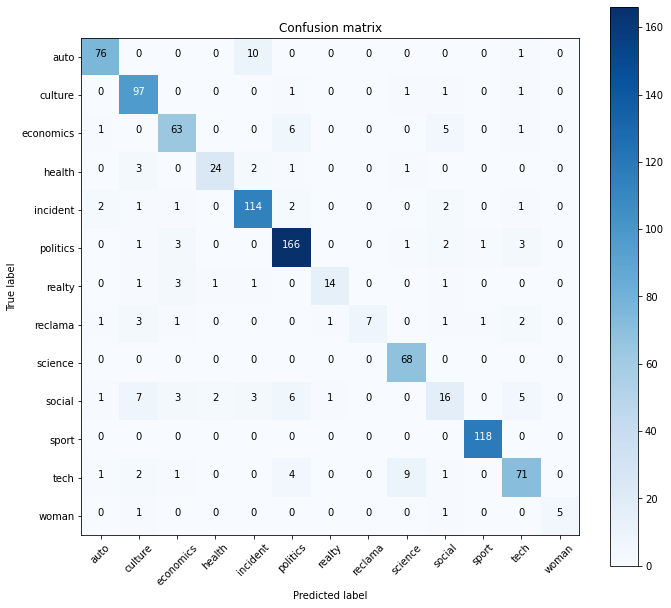

In [22]:
from matplotlib import pyplot as plt
import itertools

classes = sorted(labels.keys())
cm = confusion_matrix(y_test,o)
tick_marks = np.arange(len(classes))

plt.figure(figsize=(10,9))

plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.title('Confusion matrix')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

plt.show()

---

In [23]:
o = clf.predict(X)

labels_inv = { labels[k]:k for k in labels }
# labels_inv

for n in range(10):
    i = rng.randint(len(data))
    print('tag:',data.iloc[i,1])
    print('predict:',labels_inv[o[i]])
    print(re.sub(r'\n\s*\n',' ',data.iloc[i,0][:200])+'...')
    print('- - - - - - - - - - - - - - - - - -')
    

tag: culture
predict: culture
Американский фильм-мюзикл «Ла-Ла Ленд» получил премию Critics Choice Award в номинации «Лучший фильм». Кинокартину снял Демиен Шазелл, который был удостоен награды как лучший режиссер, пишет kommersan...
- - - - - - - - - - - - - - - - - -
tag: sport
predict: sport
Стиверн: «Не знаю ни одного спортсмена, кто не употребляет то, что выпил я»
Стиверн: «Побью Поветкина, а затем выйду против Уайлдера»
Стиверн: «Понимаю, что в России нужно быть внимательным к еде и ...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
Керри, Лавров и Штайнмайер обсуждают Сирию в Гамбурге 8 декабря 2016 в 6:50 Deutsche Welle Переговоры о ситуации в Алеппо между госсекретарем США Джоном Керри и министром иностранных дел России Сер...
- - - - - - - - - - - - - - - - - -
tag: politics
predict: politics
О девальвации венесуэльского боливара Николас Мадуро объявил почти год назад Фото: REUTERS Венесуэльский лидер Николас Мадуро 11 декабря распорядился закрыть границу

In [24]:
# https://habr.com/ru/post/205360/